In [16]:
# --- Car Price Prediction by Jared Chiew ---
# This notebook loads car data, performs EDA and preprocessing, trains a regression model to predict car prices, 
# evaluates the model, and saves the trained model and metrics.

In [17]:
# Imports & settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

In [ ]:
# Load data
DATA_PATH = "car data.csv" 
OUT_DIR = "results"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
print("\nColumns:", list(df.columns))

Shape: (301, 9)


,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0



Columns: ['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner']


In [19]:
# Detect or set target column
COMMON_TARGET_ALIASES = [
    "price", "Price", "selling_price", "Selling_Price", "selling price",
    "Selling Price", "target", "y", "label"
]

def find_target_column(df, requested=None):
    if requested:
        # case-insensitive + underscores/spaces normalization
        mapping = {c.lower().replace(" ", "_"): c for c in df.columns}
        k = requested.lower().replace(" ", "_")
        if k in mapping:
            return mapping[k]
        if requested in df.columns:
            return requested
    mapping = {c.lower().replace(" ", "_"): c for c in df.columns}
    for alias in COMMON_TARGET_ALIASES:
        k = alias.lower().replace(" ", "_")
        if k in mapping:
            return mapping[k]
    return None

# Optional override:
TARGET_COL = None   # e.g. "Selling_Price" or "price"

detected = find_target_column(df, TARGET_COL)
if detected is None:
    print("Could not auto-detect a target column. Available columns:")
    for c in df.columns:
        print(" -", c)
    raise SystemExit("Please set TARGET_COL to one of the above column names.")
else:
    TARGET_COL = detected
    print("Using target column:", TARGET_COL)

Using target column: Selling_Price


Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


None


Target summary:


count    301.000000
mean       4.661296
std        5.082812
min        0.100000
25%        0.900000
50%        3.600000
75%        6.000000
max       35.000000
Name: Selling_Price, dtype: float64


Categorical columns and unique counts:
 - Car_Name: 98 unique values
 - Fuel_Type: 3 unique values
 - Selling_type: 2 unique values
 - Transmission: 2 unique values


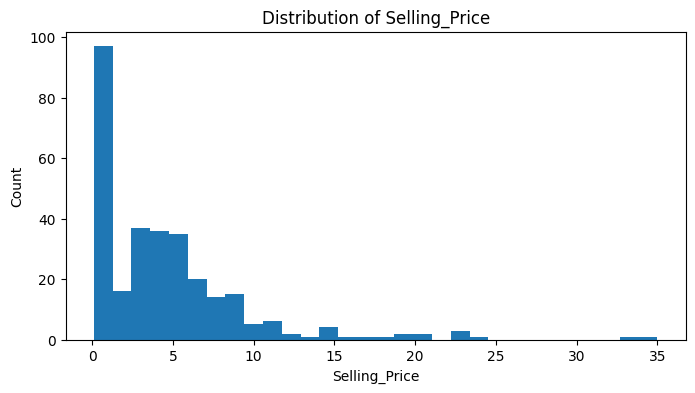

In [20]:
# Quick exploratory data analysis
print("Basic info:")
display(df.info())
print("\nTarget summary:")
display(df[TARGET_COL].describe())

# Show counts for categorical-ish columns
cat_cols = [c for c in df.columns if df[c].dtype == 'O' or df[c].dtype.name == 'category']
print("\nCategorical columns and unique counts:")
for c in cat_cols:
    print(f" - {c}: {df[c].nunique()} unique values")
    
# Histogram of the target
plt.figure(figsize=(8,4))
plt.hist(df[TARGET_COL].dropna(), bins=30)
plt.title(f"Distribution of {TARGET_COL}")
plt.xlabel(TARGET_COL)
plt.ylabel("Count")
plt.show()

In [21]:
# Basic preprocessing (drop IDs, handle missing, encode categoricals)
def basic_preprocess(df, target_col, drop_id_like=True):
    df = df.copy()
    # drop rows missing target
    df = df.dropna(subset=[target_col]).reset_index(drop=True)
    # drop obvious identifier columns (Car_Name)
    if drop_id_like:
        drop_cols = [c for c in df.columns if c.lower() in ("car_name", "name", "id")]
        if drop_cols:
            df = df.drop(columns=drop_cols)
            print("Dropped identifier columns:", drop_cols)
    # convert Year if appears numeric but as object
    if 'Year' in df.columns:
        try:
            df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
        except Exception:
            pass
    # one-hot encode categorical columns
    df_processed = pd.get_dummies(df, drop_first=True)
    return df_processed

df_proc = basic_preprocess(df, TARGET_COL)
print("After preprocessing shape:", df_proc.shape)
display(df_proc.head())

Dropped identifier columns: ['Car_Name']
After preprocessing shape: (301, 9)


,Year,Selling_Price,Present_Price,Driven_kms,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Selling_type_Individual,Transmission_Manual
0,2014,3.35,5.59,27000,0,False,True,False,True
1,2013,4.75,9.54,43000,0,True,False,False,True
2,2017,7.25,9.85,6900,0,False,True,False,True
3,2011,2.85,4.15,5200,0,False,True,False,True
4,2014,4.60,6.87,42450,0,True,False,False,True


In [22]:
# Train/test split
# Split into X and y
if TARGET_COL not in df_proc.columns:
    # if preprocessing changed the name (rare) attempt to find a close match
    matches = [c for c in df_proc.columns if c.lower().startswith(TARGET_COL.lower().replace(" ", "_"))]
    if matches:
        TARGET_COL = matches[0]
        print("Adjusted TARGET_COL after preprocess to:", TARGET_COL)
    else:
        raise SystemExit("Target column not found after preprocessing; check column names.")

X = df_proc.drop(columns=[TARGET_COL])
y = df_proc[TARGET_COL]

print("Features:", X.shape[1], "Train rows:", X.shape[0])

# split
TEST_SIZE = 0.2
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("Train / Test sizes:", X_train.shape[0], X_test.shape[0])

Features: 8 Train rows: 301
Train / Test sizes: 240 61


In [23]:
# Train model
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
model.fit(X_train, y_train)
print("Model trained.")

Model trained.


Test RMSE: 0.9061
Test R^2: 0.9644


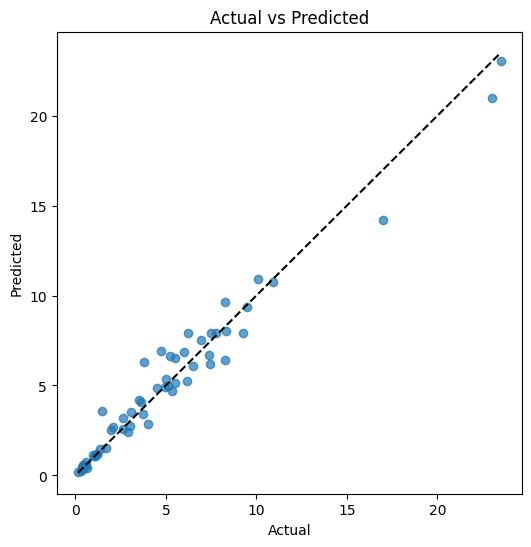

In [24]:
# Model evaluation
preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, preds)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2: {r2:.4f}")

# Plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

Present_Price              0.883566
Year                       0.062012
Driven_kms                 0.034270
Transmission_Manual        0.009408
Fuel_Type_Petrol           0.004006
Selling_type_Individual    0.002728
Fuel_Type_Diesel           0.002664
Owner                      0.001347
dtype: float64

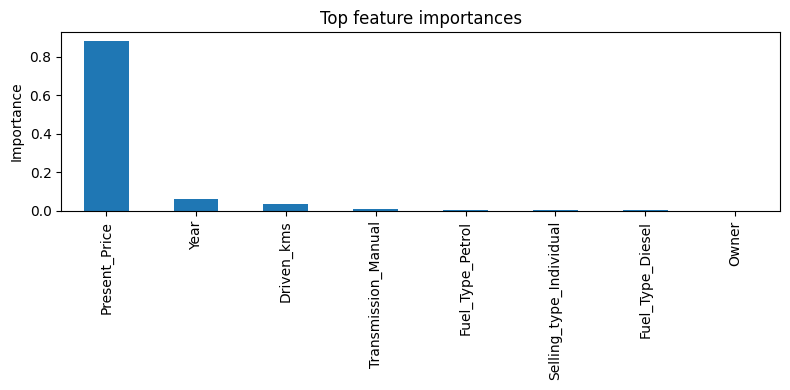

In [25]:
# Importances
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.head(20))

plt.figure(figsize=(8,4))
importances.head(15).plot(kind='bar')
plt.title("Top feature importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [26]:
# Save model and metrics
model_path = os.path.join(OUT_DIR, "rf_model.joblib")
joblib.dump(model, model_path)
print("Saved model to:", model_path)

metrics_path = os.path.join(OUT_DIR, "metrics.txt")
with open(metrics_path, "w") as f:
    f.write(f"rmse: {rmse}\nr2: {r2}\n")
print("Saved metrics to:", metrics_path)


Saved model to: task3_results\rf_model.joblib
Saved metrics to: task3_results\metrics.txt
